In [45]:
import torch
from fastai.vision.all import *
import cooler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from Bio import SeqIO

import numpy as np

# from torch.utils.data import DataLoader

In [2]:
torch.utils.data.DataLoader

torch.utils.data.dataloader.DataLoader

In [3]:
def one_hot(seq):
    seq_array = np.array(list(seq))
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq.reshape( -1, 1))
    onehot_encoded_seq = onehot_encoded_seq.reshape(onehot_encoded_seq.shape[0],-1,1 )
    onehot_encoded_seq = onehot_encoded_seq.astype('uint8')
    return onehot_encoded_seq

In [4]:
cool_path = '/media/lchumpitaz/New Volume/Data/Hi-C/mcools/GM12878_inSitu_MboI.hg19.mapq_30.1000.mcool'
fasta_path = '/media/lchumpitaz/New Volume/Data/Hi-C/hg19.fa'

In [5]:
c = cooler.Cooler(cool_path + '::/resolutions/1000')

In [6]:
arr = c.matrix(balance = True)[1000:1050,1000:1050]

/home/lchumpitaz/miniconda3/envs/zoo/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


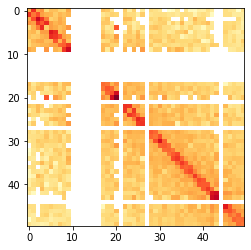

In [7]:
plt.imshow(np.log(arr), cmap = 'YlOrRd')

In [8]:
one_hot('AAAG').shape

(4, 2, 1)

In [9]:
def get_data( cool, records, win_size = 1000, examples = 10000):
    
    global x_train, y_train
    
    bins = c.bins()[:]
    max_examples = bins.index[-1] - win_size + 1
    
    exam = np.random.choice(range(max_examples) , examples, replace = False)
    
    np.random.shuffle(exam)
    
    index = 0
    for i in tqdm(exam):
        
        if index == len(x_train):
            break
        curr_bins = bins.iloc[i: i+win_size]
        
        if len(curr_bins[curr_bins['weight'] == curr_bins['weight']]) < win_size:
            continue
        
        sequence = ''
        for chrom in curr_bins['chrom'].unique():
            seq_start = curr_bins[curr_bins.chrom == chrom].iloc[0]['start']
            seq_end = curr_bins[curr_bins.chrom == chrom].iloc[-1]['end']
            for record in records:
                if record.id == chrom:
                    sequence += str(record.seq[seq_start:seq_end]).upper()
                    continue
        
        if 'N' in sequence:
            continue
        
        
        bin_start = curr_bins.index[0]
        bin_end = curr_bins.index[-1]+1
        
        arr = c.matrix(balance = True)[bin_start:bin_end,bin_start:bin_end]
        x_train[index] = one_hot(sequence)
        y_train[index] = arr
        index +=1
    return index

In [10]:
try:
    x_train = np.load('x_train.npz')['arr_0']
    y_train = np.load('y_train.npz')['arr_0']
except:
    records = list(SeqIO.parse(fasta_path,"fasta"))
    x_train = np.zeros((3000, 520000, 4, 1), dtype = 'uint8')
    y_train = np.zeros((3000, 520, 520), dtype = np.float32)
    N = get_data(c, records, win_size = 520, examples = 3000000)
    x_train = x_train[:N]
    y_train = y_train[:N]
    np.savez_compressed('x_train.npz', x_train)
    np.savez_compressed('y_train.npz', y_train)

In [46]:
    np.savez_compressed('x_train.npz', x_train)
    np.savez_compressed('y_train.npz', y_train)

In [11]:
x_train.shape

(396, 520000, 4, 1)

In [12]:
y_train.shape

(396, 520, 520)

In [13]:
def slide_output(y, index1, index2):
    if index1 > 19 or index2 > 19:
        print('Invalid')
        return None
    return y[:, index1:-(20 - index1), index2:-(20 - index2)]

/home/lchumpitaz/miniconda3/envs/zoo/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


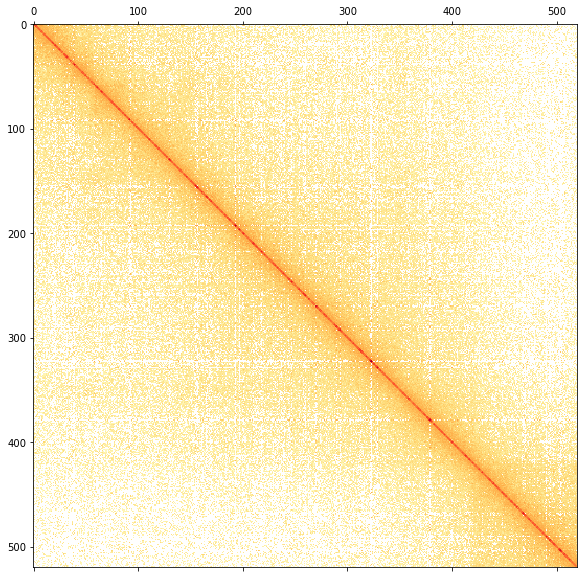

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(y_train[30]), cmap='YlOrRd');

In [15]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels= 1, out_channels= 16, kernel_size= (3, 3),  padding = 1)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size= (2, 2)) #out 32 x (250 x 250)
        
        self.conv2 = torch.nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= (3, 3),  padding = 1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size= (2, 2)) #out 64 x (125 x 125)
        
        self.conv3 = torch.nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= (2, 2))
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size= (2, 2)) #out 128 x (62 x 62)
        
        self.conv4 = torch.nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= (3, 3), stride=2)
        self.bn4 = torch.nn.BatchNorm2d(128)
        self.pool4 = torch.nn.MaxPool2d(kernel_size= (3, 3)) #out 256 x (15 x 15)
        
        self.conv5 = torch.nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= (3, 3), stride=2)
#         self.pool5 = torch.nn.AvgPool2d(kernel_size= (4, 4)) #out 1000 x (3 x 3)
    
        self.Flatten = torch.nn.Flatten()
                
        
    def add_dimension(self, x):
        x = x[:, None, :, :]
        return x
        
    def forward(self, x):
        x = self.add_dimension(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool4(x)
        
        x = self.conv5(x)
#         x = self.pool5(x)

        x = self.Flatten(x)
                
        return x

In [16]:
class fDecoder(torch.nn.Module):
    def __init__(self):
        super(fDecoder, self).__init__()
        self.linear1 = torch.nn.Linear(4096, 2048)
        self.linear2 = torch.nn.Linear(2048, 32*32*16)
        
        self.up = torch.nn.Upsample(scale_factor=2, mode='nearest')
        
        self.conv1 = torch.nn.ConvTranspose2d(16, 48, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(48) #64
                
        self.conv2 = torch.nn.ConvTranspose2d(64, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(16) #64
        
        
        
        self.conv3 = torch.nn.ConvTranspose2d(16, 48, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(48) #128
        
        self.conv4 = torch.nn.Conv2d(64, 16, kernel_size=4, bias=False)
        self.bn4 = torch.nn.BatchNorm2d(16) #125 x 125
        
        
        self.conv5 = torch.nn.ConvTranspose2d(16, 48, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = torch.nn.BatchNorm2d(48) #250
                
        self.conv6 = torch.nn.ConvTranspose2d(64, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = torch.nn.BatchNorm2d(16) #250
        
        
        self.conv7 = torch.nn.ConvTranspose2d(16, 48, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = torch.nn.BatchNorm2d(48) #500
                
        self.conv8 = torch.nn.ConvTranspose2d(64, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn8 = torch.nn.BatchNorm2d(16) #500
        
        
        self.conv9 = torch.nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)
        
        

                
        
    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        
        
        x = x.reshape(x.shape[0], 16, 32, 32)
        
        
        x_ = self.up(x)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.cat((x, x_), 1)
        x = torch.relu(self.bn2(self.conv2(x)))

        
        x_ = self.up(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.cat((x, x_), 1)
        x = torch.relu(self.bn4(self.conv4(x)))
        
        x_ = self.up(x)
        x = torch.relu(self.bn5(self.conv5(x)))
        x = torch.cat((x, x_), 1)
        x = torch.relu(self.bn6(self.conv6(x)))
        
        x_ = self.up(x)
        x = torch.relu(self.bn7(self.conv7(x)))
        x = torch.cat((x, x_), 1)
        x = torch.relu(self.bn8(self.conv8(x)))
        
        
        x = self.conv9(x)
        x = x + x.transpose(2,3)
        x = torch.sum(x, 1)
                        
        return x


In [17]:
encoder = Encoder()

In [18]:
decoder = fDecoder()

In [19]:
from torchinfo import summary
input_size_with_batch = (2,  500, 500)

_ = summary(encoder, input_size_with_batch)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [2, 16, 500, 500]         160
├─BatchNorm2d: 1-2                       [2, 16, 500, 500]         32
├─MaxPool2d: 1-3                         [2, 16, 250, 250]         --
├─Conv2d: 1-4                            [2, 32, 250, 250]         4,640
├─BatchNorm2d: 1-5                       [2, 32, 250, 250]         64
├─MaxPool2d: 1-6                         [2, 32, 125, 125]         --
├─Conv2d: 1-7                            [2, 64, 124, 124]         8,256
├─BatchNorm2d: 1-8                       [2, 64, 124, 124]         128
├─MaxPool2d: 1-9                         [2, 64, 62, 62]           --
├─Conv2d: 1-10                           [2, 128, 30, 30]          73,856
├─BatchNorm2d: 1-11                      [2, 128, 30, 30]          256
├─MaxPool2d: 1-12                        [2, 128, 10, 10]          --
├─Conv2d: 1-13                           [2, 256, 4, 4]            295,1

In [20]:
input_size_with_batch = (2, 4096)

_ = summary(decoder, input_size_with_batch)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [2, 2048]                 8,390,656
├─Linear: 1-2                            [2, 16384]                33,570,816
├─Upsample: 1-3                          [2, 16, 64, 64]           --
├─ConvTranspose2d: 1-4                   [2, 48, 64, 64]           6,912
├─BatchNorm2d: 1-5                       [2, 48, 64, 64]           96
├─ConvTranspose2d: 1-6                   [2, 16, 64, 64]           9,216
├─BatchNorm2d: 1-7                       [2, 16, 64, 64]           32
├─Upsample: 1-8                          [2, 16, 128, 128]         --
├─ConvTranspose2d: 1-9                   [2, 48, 128, 128]         6,912
├─BatchNorm2d: 1-10                      [2, 48, 128, 128]         96
├─Conv2d: 1-11                           [2, 16, 125, 125]         16,384
├─BatchNorm2d: 1-12                      [2, 16, 125, 125]         32
├─Upsample: 1-13                         [2, 16, 250, 250

In [21]:
encoder.eval()
decoder.eval()

fDecoder(
  (linear1): Linear(in_features=4096, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=16384, bias=True)
  (up): Upsample(scale_factor=2.0, mode=nearest)
  (conv1): ConvTranspose2d(16, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(16, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 16, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(16, 48, 

In [22]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [23]:
autoencoder = Autoencoder()

In [24]:
from torchinfo import summary
input_size_with_batch = (2,  500, 500)

_ = summary(autoencoder, input_size_with_batch)

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [2, 4096]                 --
|    └─Conv2d: 2-1                       [2, 16, 500, 500]         160
|    └─BatchNorm2d: 2-2                  [2, 16, 500, 500]         32
|    └─MaxPool2d: 2-3                    [2, 16, 250, 250]         --
|    └─Conv2d: 2-4                       [2, 32, 250, 250]         4,640
|    └─BatchNorm2d: 2-5                  [2, 32, 250, 250]         64
|    └─MaxPool2d: 2-6                    [2, 32, 125, 125]         --
|    └─Conv2d: 2-7                       [2, 64, 124, 124]         8,256
|    └─BatchNorm2d: 2-8                  [2, 64, 124, 124]         128
|    └─MaxPool2d: 2-9                    [2, 64, 62, 62]           --
|    └─Conv2d: 2-10                      [2, 128, 30, 30]          73,856
|    └─BatchNorm2d: 2-11                 [2, 128, 30, 30]          256
|    └─MaxPool2d: 2-12                   [2, 128, 10, 10]          --
| 

In [25]:
autoencoder.eval()

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool4): MaxPool2d

In [26]:
torch.cuda.empty_cache()


In [27]:
train_y = torch.from_numpy(slide_output(y_train, 0, 0))

In [28]:
test_y = torch.from_numpy(slide_output(y_train, 10, 10))

In [29]:
trainset = torch.utils.data.TensorDataset(train_y,train_y)

In [30]:
testset = torch.utils.data.TensorDataset(test_y,test_y)

In [31]:
batch_size = 4
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [32]:
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [33]:
def fit(model, dataloader, loss, optimizer, device, epochs= 5):
    model.train()
    for epoch in tqdm(range(epochs)):
        running_cost = 0.0
        for i, data in enumerate(tqdm(dataloader, leave = False)):
            inputs, targets = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            J = loss(outputs, inputs)
            J.backward()
            optimizer.step()

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
# loss = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-5)
# fit(autoencoder, trainloader, loss, optimizer, device, epochs= 20)

In [36]:
data = DataLoaders(trainloader, testloader)
autoencoder.to(device)
data.to(device)
learn = Learner(data, autoencoder, loss_func=torch.nn.MSELoss(reduction = 'sum'))


In [37]:
torch.cuda.empty_cache()

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=1.9054607491852948e-06)

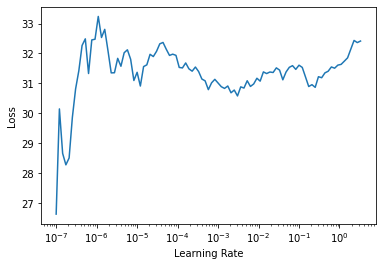

In [43]:
learn.lr_find(suggestions=True)

In [44]:
learn.fit_one_cycle(100, 0.07585775852203369)

epoch,train_loss,valid_loss,time
0,32.477802,32.291500,00:22
1,32.477642,32.290997,00:23
2,32.477425,32.289497,00:20
3,32.477142,32.286762,00:26
4,32.476856,32.282215,00:23
5,32.476631,32.274986,00:20
6,32.476456,32.264244,00:26
7,32.476364,32.249844,00:23
8,32.476299,32.232143,00:20
9,32.476276,32.212124,00:22


KeyboardInterrupt: 

In [40]:
# p = encoder(train_y[0:2].to(device))
# prediction = p.detach().cpu().numpy()


In [41]:
p = autoencoder(train_y[0:2].to(device))
prediction = p.detach().cpu().numpy()
target = train_y[0:2].detach().cpu().numpy()

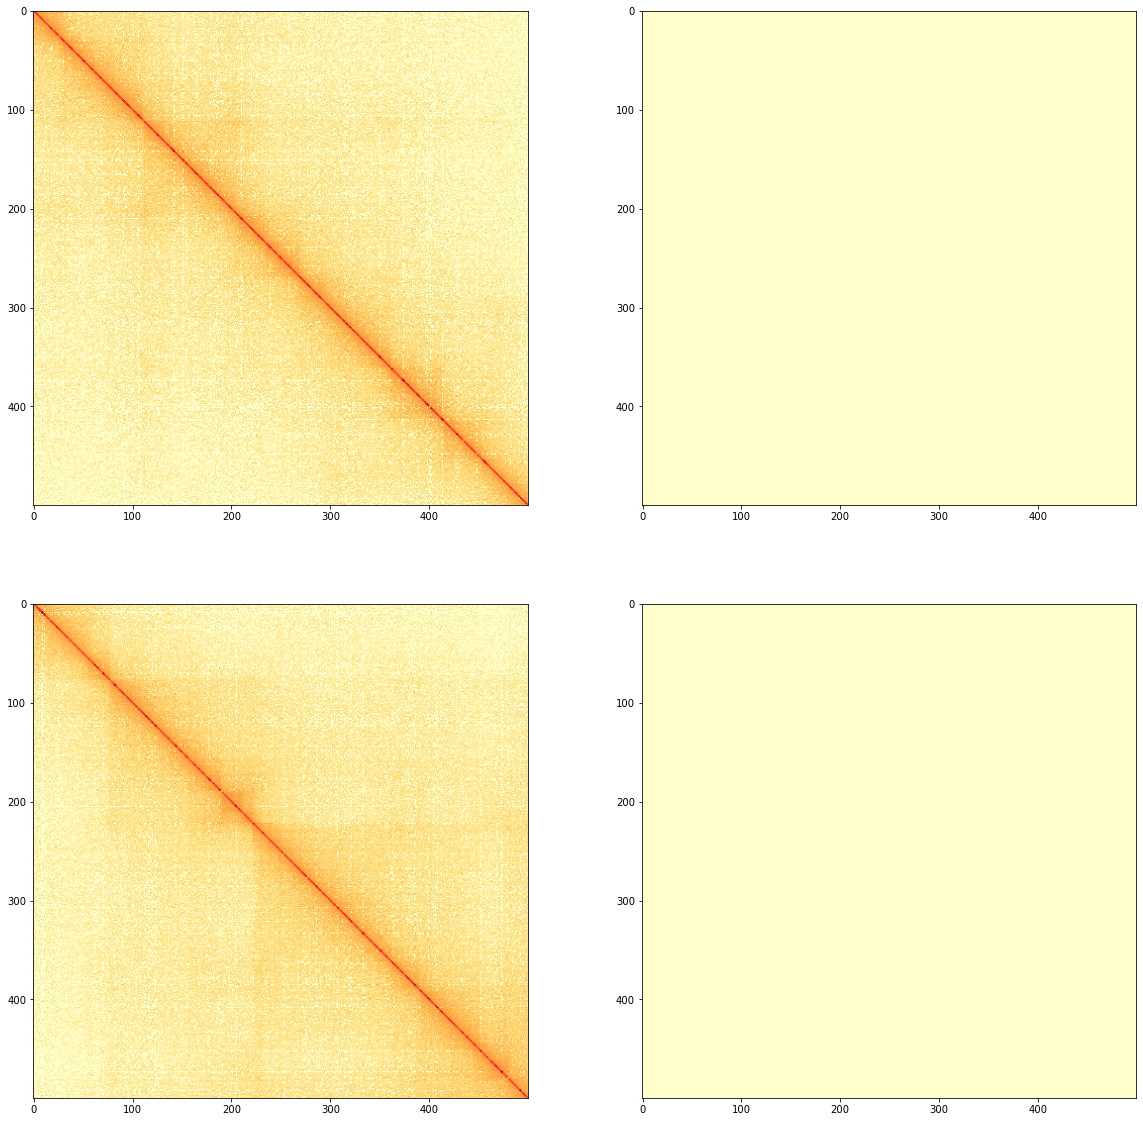

In [42]:
plt.figure(figsize=(20, 20))
bias = 1e-4
plt.subplot(221)
plt.imshow(np.log(target[0]+bias), cmap='YlOrRd');
plt.subplot(222)
plt.imshow(np.log(prediction[0]+bias), cmap='YlOrRd');
plt.subplot(223)
plt.imshow(np.log(target[1]+bias), cmap='YlOrRd');
plt.subplot(224)
plt.imshow(np.log(prediction[1]+bias), cmap='YlOrRd');